In [178]:
import cv2
import scipy
from scipy import stats
import numpy as np
from collections import defaultdict


In [179]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [230]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# Read image from file
image = cv2.imread('/content/gdrive/MyDrive/OpenCV Project/vk.jpeg')

# Get the original image size
height, width, _ = image.shape

# Set the desired width for the resized image
desired_width = 400

# Calculate the scaling factor for the resize operation
scale_factor = desired_width / width

# Resize the image using the calculated scaling factor
image = cv2.resize(image, (int(width * scale_factor), int(height * scale_factor)))


In [223]:
def sharpen_frame(img):
  kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
  cv2.filter2D(img, -1, kernel, img, borderType=cv2.BORDER_CONSTANT)

  



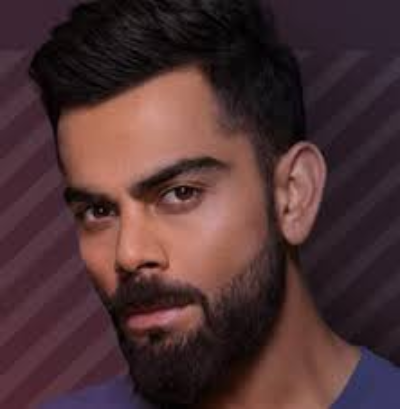

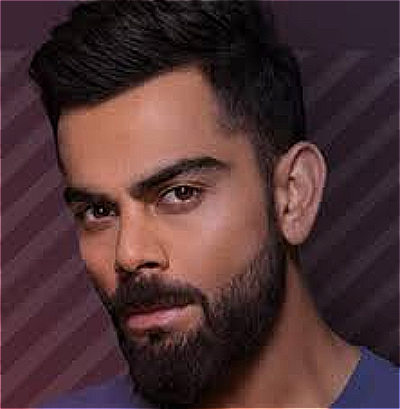

In [225]:
cv2_imshow(image)
sharpen_frame(image)
cv2_imshow(image)

In [231]:
def update_c(C,hist):
    while True:
        groups=defaultdict(list)

        for i in range(len(hist)):
            if(hist[i] == 0):
                continue
            d=np.abs(C-i)
            index=np.argmin(d)
            groups[index].append(i)

        new_C=np.array(C)
        for i,indice in groups.items():
            if(np.sum(hist[indice])==0):
                continue
            new_C[i]=int(np.sum(indice*hist[indice])/np.sum(hist[indice]))

        if(np.sum(new_C-C)==0):
            break
        C=new_C

    return C,groups


In [184]:
# Calculates K Means clustering
def K_histogram(hist):

    alpha=0.001
    N=80
    C=np.array([128])

    while True:
        C,groups=update_c(C,hist)

        new_C=set()
        for i,indice in groups.items():
            if(len(indice)<N):
                new_C.add(C[i])
                continue

            z, pval=stats.normaltest(hist[indice])
            if(pval<alpha):
                left=0 if i==0 else C[i-1]
                right=len(hist)-1 if i ==len(C)-1 else C[i+1]
                delta=right-left
                if(delta >=3):
                    c1=(C[i]+left)/2
                    c2=(C[i]+right)/2
                    new_C.add(c1)
                    new_C.add(c2)
                else:
                    new_C.add(C[i])
            else:
                new_C.add(C[i])
        if(len(new_C)==len(C)):
            break
        else:
            C=np.array(sorted(new_C))
    return C


In [232]:
def unique_colors(img) :
  # Convert the image to RGB
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Get the unique colors in the image
  unique_colors = len(set(map(tuple, img.reshape(-1, 3))))

  # Print the number of unique colors in the image
  return unique_colors


In [186]:
# def posterize(img):
#     # Apply the posterize effect with 15 bins
#     num_colors = 11
#     quantized = img.copy()
#     quantized = quantized // (256 // num_colors)
#     quantized = quantized * (256 // num_colors)
#     return quantized

# cv2_imshow(posterize(image))
# print(unique_colors(image))
# print(unique_colors(posterize(image)))

In [253]:
def cartoonise(img):
    kernel=np.ones((2,2), np.uint8)
    output=np.array(img)
    x,y,c=output.shape
    for i in range(c):
        output[:,:,i]=cv2.bilateralFilter(output[:,:,i],7,150,150)

    # Edge detection
    edge=cv2.Canny(output, 40, 100)
    print("\nEdge Detection Output:")
    cv2_imshow(edge)

    # Color Histogram Calculation
    output=cv2.cvtColor(output,cv2.COLOR_RGB2HSV)
    hists = []
    for i in range(c):
        hist, _ = np.histogram(output[:,:,i],bins=np.arange(256+1))
        hists.append(hist)
        print("\n")
        print(f"\nColor {i} Histogram:\n")
        print(hist)

    # Calculate K-Means Centroids
    C=[]
    for h in hists:
        C.append(K_histogram(h))
    print("\ncentroids: {0}\n".format(C))

    # Quantize the colors in the image
    output=output.reshape((-1,c))
    for i in range(c):
        channel=output[:,i]
        index=np.argmin(np.abs(channel[:, np.newaxis] - C[i]), axis=1)
        output[:,i]=C[i][index]
    output=output.reshape((x,y,c))
    output=cv2.cvtColor(output, cv2.COLOR_HSV2RGB)

    # Find and draw contours
    contours,_=cv2.findContours(edge,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    print(f"\nNumber of Contours: {len(contours)}\n")
    cv2.drawContours(output,contours,-1,0,thickness=1)
    print("\n")
    cv2_imshow(output)

    # Erosion 
    for i in range(3):
      output[:,:,i]=cv2.erode(output[:,:,i], kernel, iterations=1)

    # output = posterize(output)
    print('\nNumber of unique colors=',unique_colors(output))

    return output



Edge Detection Output:


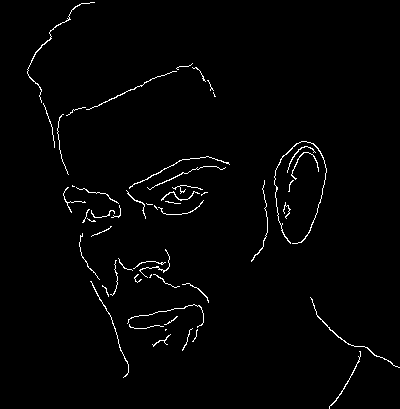




Color 0 Histogram:

[  266   237   129   109    57     1     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     3     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     2     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
    16     0     0     0     0     0     0     0     0     0     3     0
     0     0     0     7     0     0     0     0     3     0     0     5
     0     0     0     0     0     0    67     0     0     2     0     0
    15     5    49     4    63     5    33    11    14   132    45   111
   188   256   636  1022  4704 12200 13743  9952  5755  4144  3876  2415
  7230  1345  1736  3666  1146  2563  1487   528  3923  5271 17928  2234
  2087  3378   760  4576  4650   579  3501   581   621  1040   215  9804
   431  4736   340   598  2888    27  1484    28  1036   154  3960   106
   166    59   269   331  15

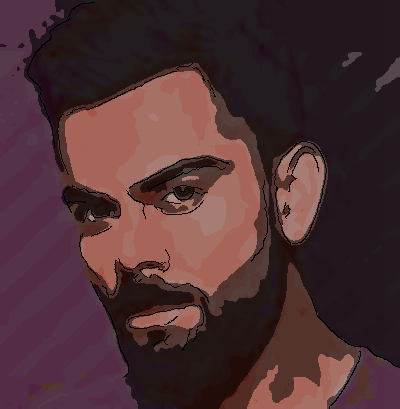


Number of unique colors= 64


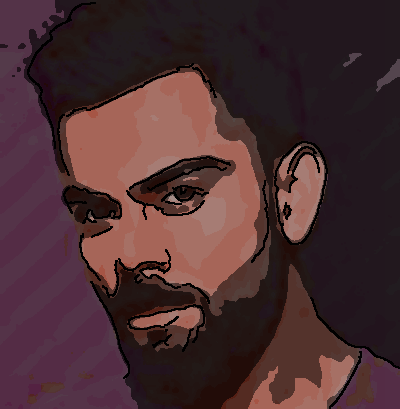

In [254]:
output=cartoonise(image)
# cv2.imwrite("cartoon.jpg", output)
cv2_imshow(output)


In [ ]:
!pip install opencv-python-headless


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
from moviepy.editor import *

# Define the input and output paths
input_gif_path = "/content/gdrive/MyDrive/OpenCV Project/cat-high5.gif"
input_video_path = "/content/gdrive/MyDrive/OpenCV Project/cat.mp4"

# Convert the GIF to MP4 using MoviePy
clip = VideoFileClip(input_gif_path)
clip.write_videofile(input_video_path)

Moviepy - Building video /content/gdrive/MyDrive/OpenCV Project/cat.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/OpenCV Project/cat.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/OpenCV Project/cat.mp4


In [96]:
# # Define the input and output video paths
# input_video_path = '/content/gdrive/MyDrive/OpenCV Project/test_video.mp4'
output_video_path = '/content/gdrive/MyDrive/OpenCV Project/cat_video_out.mp4'

# Open the input video file
input_video = cv2.VideoCapture(input_video_path)



In [97]:
# Get the input video properties
frame_count = int(input_video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(input_video.get(cv2.CAP_PROP_FPS))

# Create the output video writer 
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_fps = fps
output_video = cv2.VideoWriter(output_video_path, fourcc, output_fps, (frame_width, frame_height))


In [95]:
def cartoonise_video_frame(img):

    #bilateral filtering to preserve edges
    kernel = np.ones((2,2), np.uint8)
    output = np.array(img)
    x, y, c = output.shape
    for i in range(c):
        output[:,:,i] = cv2.bilateralFilter(output[:,:,i], 7, 200, 300)

    # Edge detection
    edge = cv2.Canny(output, 100, 200)

    # Color Histogram Calculation
    output = cv2.cvtColor(output, cv2.COLOR_RGB2HSV)
    hists = []
    for i in range(c):
        hist, _ = np.histogram(output[:,:,i], bins=np.arange(256+1))
        hists.append(hist)

    # Calculate K-Means Centroids
    C=[]
    for h in hists:
        C.append(K_histogram(h))

    # Quantize the colors in the image
    output = output.reshape((-1, c))
    for i in range(c):
        channel = output[:,i]
        index = np.argmin(np.abs(channel[:, np.newaxis] - C[i]), axis=1)
        output[:,i] = C[i][index]
    output = output.reshape((x, y, c))
    output = cv2.cvtColor(output, cv2.COLOR_HSV2RGB)

    # Find and draw contours
    contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(output, contours, -1, 0, thickness=1)

    # Erosion to make the lines thinner
    for i in range(3):
      output[:,:,i] = cv2.erode(output[:,:,i], kernel, iterations=1)

    # output =   posterize(output)
    return output


In [99]:
# Define the total number of frames in the input video
frame_count = int(input_video.get(cv2.CAP_PROP_FRAME_COUNT))

# Create a Non-local Means Denoising object
nl_means = cv2.fastNlMeansDenoisingColored


# Loop through the frames in the input video
for i in range(frame_count):
  # Read the next frame from the input video
  ret, frame = input_video.read()

  # Check if the frame was successfully read
  if not ret:
    break

  #sharpen frame
  sharpen_frame(frame)
  
  # Apply fast non-local means denoising to the frame
  denoised_frame = cv2.fastNlMeansDenoisingColored(frame, None, 10, 10, 7, 21)

  # Apply the cartoon effect to the frame
  cartoon_frame = cartoonise_video_frame(denoised_frame)

  # Write the processed frame to the output video
  output_video.write(cartoon_frame)

  # Print the progress bar
  progress = i / frame_count
  bar_length = 50
  filled_length = int(progress * bar_length)
  bar = '=' * filled_length + '-' * (bar_length - filled_length)
  print(f'\rProcessing frames: [{bar}] {int(progress * 100)}%', end='')

# Release the video objects
input_video.release()
output_video.release()


Processing frames: [==============================================----] 93%

END


In [ ]:
# import cv2

# # Load the input video
# input_video = cv2.VideoCapture('/content/gdrive/MyDrive/OpenCV Project/output_video.mp4')

# # Get video properties
# frame_width = int(input_video.get(cv2.CAP_PROP_FRAME_WIDTH))
# frame_height = int(input_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
# fps = int(input_video.get(cv2.CAP_PROP_FPS))

# # Define the codec for output video
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# # Create an output video writer
# output_video = cv2.VideoWriter('/content/gdrive/MyDrive/OpenCV Project/Tuned.mp4', fourcc, fps, (frame_width, frame_height))

# # Create a Lucas-Kanade optical flow object
# lk_params = dict(winSize=(21, 21), maxLevel=3, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 4, 0.03))

# # Set up a background subtractor object
# background_subtractor = cv2.createBackgroundSubtractorMOG2()

# # Initialize the previous frame and previous points
# prev_frame = None
# prev_points = None

# # Loop through the video frames
# while True:
#     # Read the next frame
#     ret, frame = input_video.read()

#     # If there are no more frames, break out of the loop
#     if not ret:
#         break

#     # Apply background subtraction to the frame
#     fg_mask = background_subtractor.apply(frame)

#     # Dilate the foreground mask to fill in gaps
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
#     fg_mask = cv2.dilate(fg_mask, kernel, iterations=3)

#     # Apply a median filter to the foreground mask to remove noise
#     fg_mask = cv2.medianBlur(fg_mask, 5)

#     # Convert the frame to grayscale
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # If this is the first frame, initialize the previous frame and previous points
#     if prev_frame is None:
#         prev_frame = gray
#         prev_points = cv2.goodFeaturesToTrack(prev_frame, maxCorners=30, qualityLevel=0.8, minDistance=5, blockSize=5)

#     # Compute optical flow from the previous frame to the current frame
#     next_points, status, err = cv2.calcOpticalFlowPyrLK(prev_frame, gray, prev_points, None, **lk_params)

#     # Select only the points that were successfully tracked
#     good_next_points = next_points[status == 1]
#     good_prev_points = prev_points[status == 1]

#     # Compute the motion vectors of the tracked points
#     motion_vectors = good_next_points - good_prev_points

#     # Create a mask based on the motion vectors
#     mag, ang = cv2.cartToPolar(motion_vectors[..., 0], motion_vectors[..., 1])
#     mask = cv2.inRange(mag, 2, 10)

#     # Apply the mask to the original frame
#     mask = cv2.resize(mask, (frame_width, frame_height))
#     smoothed_frame = cv2.bitwise_and(frame, frame, mask=mask)  

#     # Write the smoothed frame to the output video
#     output_video.write(smoothed_frame)

#     # Display the smoothed frame
#     cv2_imshow(smoothed_frame)

#     # Update the previous frame and previous points
#     prev_frame = gray
#     prev_points = cv2.goodFeaturesToTrack(prev_frame, maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

#     # # Print the progress bar
#     # progress = i / frame_count
#     # bar_length = 50
#     # filled_length = int(progress * bar_length)
#     # bar = '=' * filled_length + '-' * (bar_length - filled_length)
#     # print(f'\rProcessing frames: [{bar}] {int(progress * 100)}%', end='')



In [ ]:
# #copy image
# img = image

# # Create a Gaussian pyramid of the image
# G = img.copy()
# gpA = [G]
# for i in range(6):
#     G = cv2.pyrDown(G)
#     gpA.append(G)

# # Create a Laplacian pyramid of the image
# lpA = [gpA[5]]
# for i in range(5, 0, -1):
#     GE = cv2.pyrUp(gpA[i])
#     L = cv2.resize(gpA[i-1], (GE.shape[1], GE.shape[0])) # resize gpA[i-1] to match GE shape
#     L = cv2.subtract(L, GE)
#     lpA.append(L)

# # Create a Gaussian pyramid of a blurred version of the image
# G = cv2.GaussianBlur(img, (5, 5), 0)
# gpB = [G]
# for i in range(6):
#     G = cv2.pyrDown(G)
#     gpB.append(G)

# # Create a Laplacian pyramid of the blurred image
# lpB = [gpB[5]]
# for i in range(5, 0, -1):
#     GE = cv2.pyrUp(gpB[i])
#     L = cv2.resize(gpB[i-1], (GE.shape[1], GE.shape[0])) # resize gpB[i-1] to match GE shape
#     L = cv2.subtract(L, GE)
#     lpB.append(L)

# # Combine the Laplacian pyramids of the original and blurred images
# LS = []
# for la, lb in zip(lpA, lpB):
#     rows, cols, dpt = la.shape
#     ls = cv2.addWeighted(la, 1.5, lb, -0.5, 0)
#     LS.append(ls)

# # Reconstruct the image from the Laplacian pyramid
# ls_ = LS[0]
# for i in range(1, 6):
#     ls_ = cv2.pyrUp(ls_)
#     ls_ = cv2.resize(ls_, (LS[i].shape[1], LS[i].shape[0])) # resize ls_ to match LS[i] shape
#     ls_ = cv2.add(ls_, LS[i])

# # Display the original and sharpened images
# cv2_imshow(img)
# cv2_imshow(ls_)